# End-to-End Project from Hands-on ML Book Ch.2

Here we duplicate the end-to-end project from ML book. This analysis looks at housing data in California. It will build predictors for housing value (a continuous outcome) based on other attributes.

## Fetching Data

This function downloads dataset

In [1]:
import os 
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


This function loads the dataset as apandas DataFrame object

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Load and take a quick look at data

In [3]:
fetch_housing_data()

In [4]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Let's print a table of value counts for the "ocean_proximity" attribute

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Use the `describe` method to see a summary of all variables

In [7]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

Let's make histograms of all variables


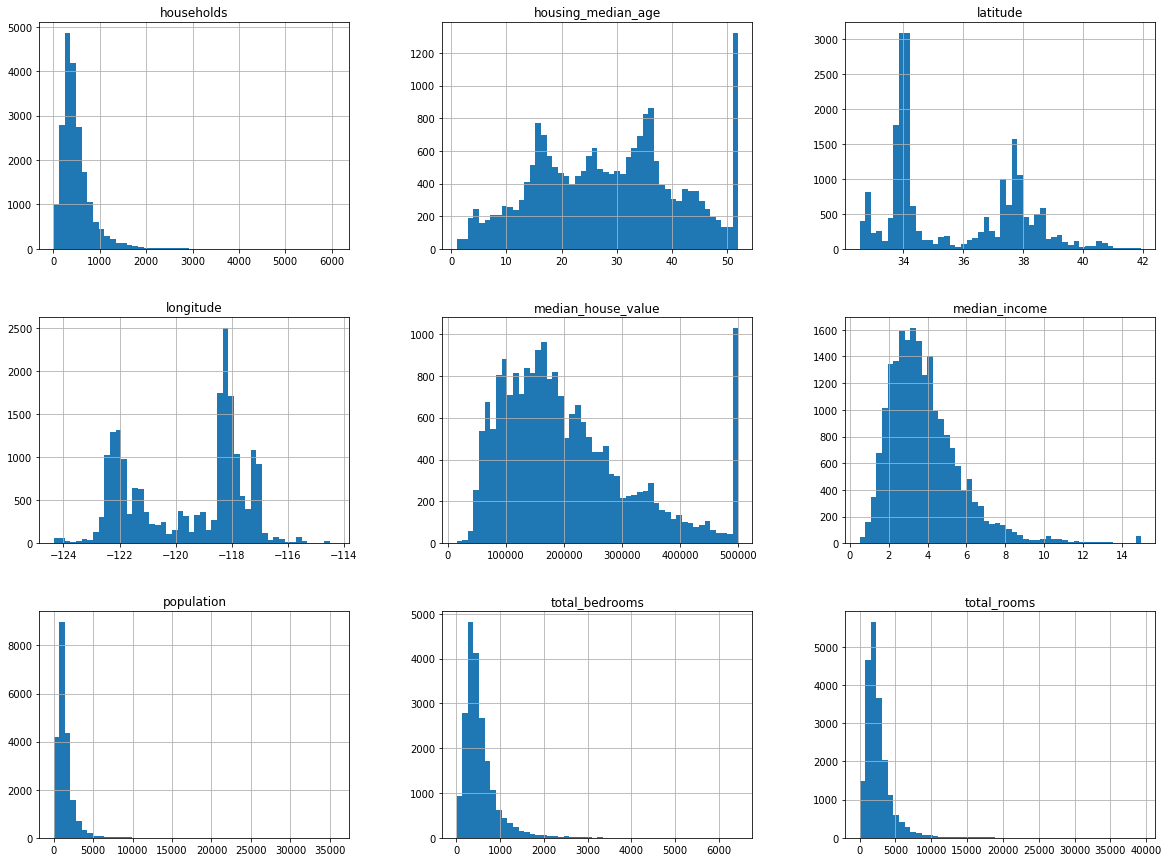

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Create a Test Set

Next, let's create a test set which we will ignore during system development. We think that median income will be important for predicting house prices so we will make sure that both test and train set retain the same distribution of median income (as much as possible). To do so, instead of using random sampling to create the test set, we will use stratified sampling using a categorical version of the median income attribute to stratify the dataset.

First, we create a categorical median income attribute

In [9]:
import numpy as np

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Let's take a look at the distribution of the categorical income attribute

In [10]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Next, we use a function from the scikit.learn package for stratified sampling and verify that the train and test sets both have similar distribution of categorical income as the overall dataset.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]
    
train_set["income_cat"].value_counts() / len(train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [12]:
test_set["income_cat"].value_counts() / len(test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Looks good enough. Finally, remove the income categorical variable from the train and test sets since we don't need them anymore

In [13]:
for set in (train_set, test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Exploratory Data Analysis

First, let's rename the training dataset to make it easier to refer to.

In [14]:
housing = train_set.copy()

Let's make a scatter plot of latitude and longitude using population for size, and house value for color

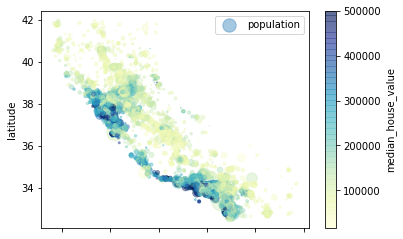

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("YlGnBu"), colorbar=True)
plt.legend()

Let's look at attribute correlation

In [16]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690077
total_rooms           0.131453
housing_median_age    0.099620
households            0.064110
total_bedrooms        0.048565
population           -0.023790
longitude            -0.047697
latitude             -0.144086
Name: median_house_value, dtype: float64

Median income has the highest correlation, total rooms and latitude also have high correlation to the outcome we are trying to predict. We can also make a scatterplot matrix.

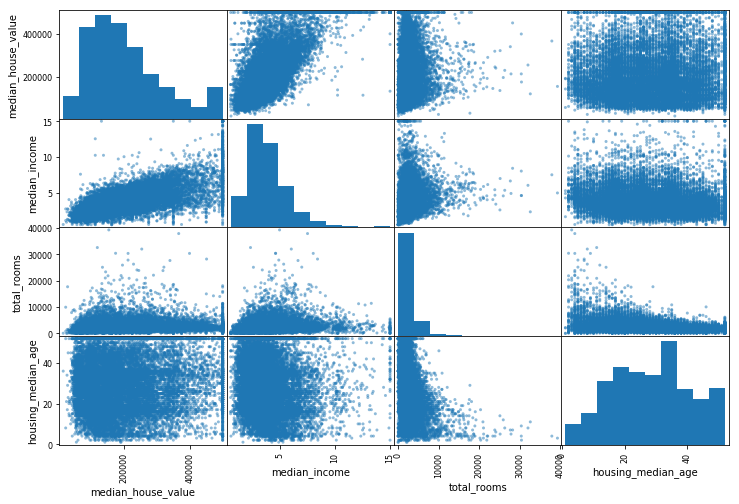

In [17]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

Correlation between median income (attribute) and median house value (outcome) is clear. Let's take a closer look.

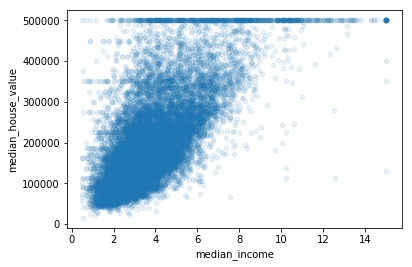

In [18]:
housing.plot.scatter(x="median_income", y="median_house_value", alpha=0.1)
plt.show()

There are horizontal bands at some specific house values. This could be an issue from how the data was obtained. It may be difficult for our models to catch this properly.

Let's normalize a few of the attributes and see if that improves some of the correlations we observed.

In [19]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690077
rooms_per_household         0.153156
total_rooms                 0.131453
housing_median_age          0.099620
households                  0.064110
total_bedrooms              0.048565
population_per_household   -0.022425
population                 -0.023790
longitude                  -0.047697
latitude                   -0.144086
bedrooms_per_room          -0.261785
Name: median_house_value, dtype: float64

Normalizing total rooms improved correlation slightly, normalizing total bedrooms made a big difference, normalizing population did not.

## Data cleaning

Let's start over again with the training set and remove the outcome column so it is not transformed by our preprocessing pipeline

In [20]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

Let's use sklearn pipelines to clean up and transform our data based on what we've observed after exploratory analysis. We will do the following:

- impute missing values for continuous attributes by the median
- convert categorical attributes into numeric attributes using one-hot encoding (one indicator attribute for each categorical attribute category)
- add the normalized attributes created above
- standardize numerical attributes (center and scale attributes)

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler, LabelBinarizer
from sklearn_pandas import DataFrameMapper

cat_attributes = ['ocean_proximity']
num_attributes = [x for x in list(housing) if x not in cat_attributes]

# This transformer adds the normalized attributes we looked at above
class NormalizedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.rooms_ix = 3
        self.bedrooms_ix = 4
        self.population_ix = 5
        self.household_ix = 6 
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, self.rooms_ix] / X[:, self.household_ix]
        population_per_household = X[:, self.population_ix] / X[:, self.household_ix]
        bedrooms_per_room = X[:, self.bedrooms_ix] / X[:, self.rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', NormalizedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

full_pipeline = DataFrameMapper([
    (cat_attributes, LabelBinarizer()),
    (num_attributes, num_pipeline)
])

Now that we have our pipeline in place, let's transform our training set

In [29]:
housing_clean = full_pipeline.fit_transform(housing)
housing_clean

array([[ 1.        ,  0.        ,  0.        , ...,  0.26475127,
         0.00551682, -0.73500197],
       [ 0.        ,  1.        ,  0.        , ...,  0.26651988,
         0.0414772 , -0.42934168],
       [ 1.        ,  0.        ,  0.        , ...,  0.27524382,
        -0.02772603, -0.68131709],
       ..., 
       [ 0.        ,  1.        ,  0.        , ...,  0.07827607,
        -0.05775098, -0.51787497],
       [ 1.        ,  0.        ,  0.        , ...,  0.41030893,
        -0.07140763, -0.77043248],
       [ 1.        ,  0.        ,  0.        , ...,  0.55994837,
        -0.02628079, -1.03871657]])

In [30]:
housing_clean.shape

(16512, 16)

## Model Training and Selection

Let's train a linear regression model and a regression tree model

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

lin_reg = LinearRegression()
lin_reg.fit(housing_clean, housing_labels)

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_clean, housing_labels);

Now let's calculate the root mean squared error of each on the training set

In [32]:
from sklearn.metrics import mean_squared_error

linreg_predictions = lin_reg.predict(housing_clean)
linreg_mse = mean_squared_error(housing_labels, linreg_predictions)
linreg_rmse = np.sqrt(linreg_mse)

tree_predictions = tree_reg.predict(housing_clean)
tree_mse = mean_squared_error(housing_labels, tree_predictions)
tree_rmse = np.sqrt(tree_mse)

print("linreg: ", linreg_rmse)
print("tree: ", tree_rmse)

linreg:  68056.5832718
tree:  0.0


Looks like the regression tree is probably overfitting the training set. Let's use cross-validation to estimate expected prediction error instead.

In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_clean, housing_labels, 
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Sd:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [ 72662.87860081  71247.46361178  70949.80359951  66701.68492298
  68782.40923838  69759.28963784  67494.27415908  69840.0388032
  67662.13333456  68518.06542215]
Mean: 69361.804133
Sd: 1784.98253319


Clearly, the Regression tree is overfitting the training set. Let's see how linear regression fares:

In [34]:
scores = cross_val_score(lin_reg, housing_clean, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
linreg_rmse_scores = np.sqrt(-scores)
display_scores(linreg_rmse_scores)

Scores: [ 69017.00136083  71088.90705755  65485.31301251  65466.23799191
  68477.25257987  69148.41135686  69661.78851225  70450.89086082
  65303.44818922  70184.65730709]
Mean: 68428.3908229
Sd: 2093.87671852


In this case, linear regression does better than the regression tree based on the CV estimate. Let's try one more model, the random forest, which we'll see in a later lecture.

In [35]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, housing_clean, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [ 53729.79433671  53687.73985371  50138.65699557  48387.47656515
  54000.18031438  52842.11377842  52750.27486711  52335.04933206
  53067.50098932  50097.19247227]
Mean: 52103.5979505
Sd: 1799.8203922


This model looks promising. Let's now use grid search over tuning parameters for the random forest regressor using cross validation to perform model selection.

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error")
grid_search.fit(housing_clean, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

We can get the best predictor after grid search, which was re-trained on the complete training set. Using that we can look at feature importance for that predictor.

In [37]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(housing["ocean_proximity"])

feature_importances = grid_search.best_estimator_.feature_importances_
extra_attributes = ['rooms_per_household', 'pop_per_household', 'bedrooms_per_room']
cat_encoded_attributes = list(encoder.classes_)
attributes = num_attributes + extra_attributes + cat_encoded_attributes
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3500879236240505, 'INLAND'),
 (0.1726012716867554, 'latitude'),
 (0.10626207695473866, 'NEAR BAY'),
 (0.073945754321551677, 'NEAR OCEAN'),
 (0.070926613211463721, 'population'),
 (0.060536990833073255, 'households'),
 (0.044414134624439806, 'ISLAND'),
 (0.040209218481020312, 'median_income'),
 (0.017314545269586194, 'rooms_per_household'),
 (0.016698823573838575, 'bedrooms_per_room'),
 (0.016698293344201903, 'pop_per_household'),
 (0.015723884053047196, '<1H OCEAN'),
 (0.0083763591949719308, 'longitude'),
 (0.0037504961369149792, 'total_bedrooms'),
 (0.0021040102327595568, 'total_rooms'),
 (0.00034960445758629838, 'housing_median_age')]

## Evaluate performance on test set

Now that we have trained our random forest regressor using cross validation, we are ready to see how this does on the test set. In this case, we are not pursuing any further fine tuning of our model, e.g., removing some of the uninformative attributes, transforming attributes further (e.g., ignoring categories for proximity other than 'INLAND'), etc. If we were doing that, we would not be measuring performance on the test set. Remember, do not touch the test set until you are done developing the ML system.

Note that we will use the same preprocessing pipeline as before.

In [38]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_clean = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_clean)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("Final RMSE:", final_rmse)

Final RMSE: 50779.967118
